# Исследование данных о продажах игр в интернет-магазине.

## Описание задачи:
Цель данного проекта в исследовании данных продаже игр на различных платформах и различных регионах.
Данные содержат информацию о продаж конкретной игры для конкретной платформы разделённые по основным регионам. 
<a id='list'>
Необходимые исследования:
- [Кол-во игр выпущенных за разные годы](#number_of_games_per_year)
- [Исследование распределения продаж по платформам](#sales_per_platform)
- [Исследование кореляции отывов критиков и пользователей с продажами игр](#sales_critics_corr)
- [Распределение игр по жанрам](#genre_dist)
- Исследовавние региональных особенностей в продаже игр
    - [Топ-5 популярных платформ по регионам](#top5_platform)
    - [Топ-5 популярных жанров по регионам](#top5_genres)
    - [Корреляция рейтинга ESRP и кол-ва продаж, по регионам](#esrp_sales_corr)
- Проверка статистических гипотез
    - [Об одинаковости пользовательских рейтингов платформ XOne и PC](#h_xone_pc_same_rating)
    - [О разности в пользовательских рейтингах для жанров Action и Sports](#h_action_sport_not_same_rating)
    
[к выводу](#resume)  
</a>
***

### Импортирование модулей


In [1]:
#data
import pandas as pd
#visial
import matplotlib.pyplot as plt
import seaborn as sns
#math and stat
from scipy import stats as st
import math

### Установка настроек
Установка настроек pandas для удобства отображения данных.

In [4]:
pd.set_option('display.float_format', '{:.2f}'.format)

## Загрузка данных и их первоначальное изучение

### Загрузка датасета
Загрузка и первичное знакомство с данными.

In [48]:
df = pd.read_csv('games.csv')
df.head(3)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E


### Общая информация о данных.
С помощью метода .info() выведена общая информацию о дата-фрейме. Оценка кол-во явных пропусков с NaN значениями, определение каким типам данным принадлежат колонки.

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


По первому взгляду можно сказать о небольшом кол-вом пропусков в большинстве столбцов. Данные в некоторых столбцах хранятся не оптимально. Множество пропусков в колонках с рейтингом и возрастной категорией.
***
## Предобработка данных.
### Замена названий столбцов
Приведение названий столбцов к нижнему регистру.

In [58]:
df = df.rename(columns= dict((x, x.lower()) for x in df.columns))
df.columns.to_list()


['name',
 'platform',
 'year_of_release',
 'genre',
 'na_sales',
 'eu_sales',
 'jp_sales',
 'other_sales',
 'critic_score',
 'user_score',
 'rating']

### Обработка пропусков.
Визуализация кол-ва пропусков.

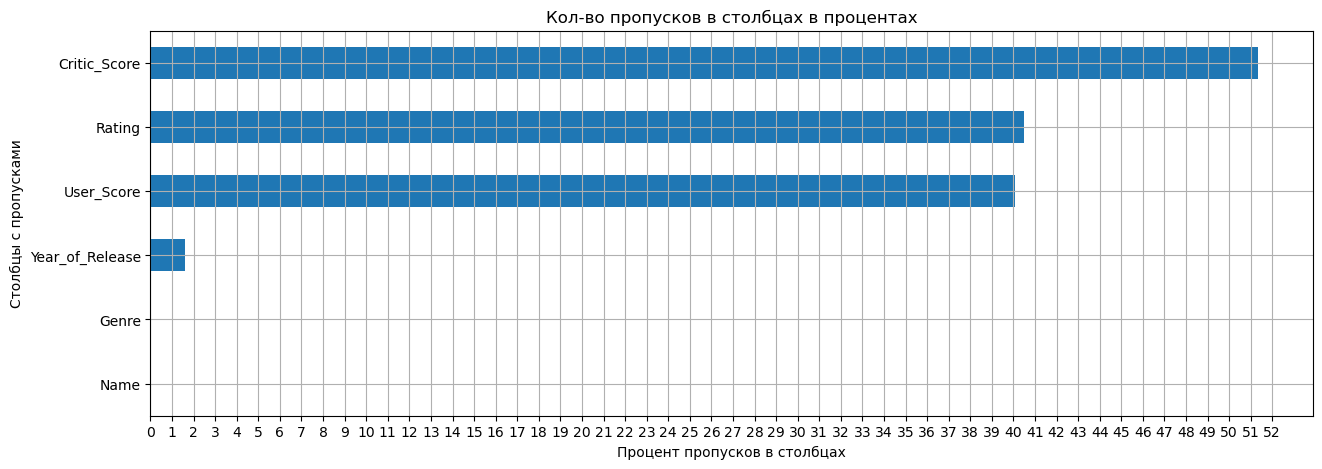

In [52]:
((t:=(df.isna().mean()*100)
    .to_frame(name='missing')
    .query('missing>0'))
    .sort_values(by='missing')
    .plot.barh(
        figsize=(15,5),
        grid=True,
        xticks = [x for x in range(0, int(t['missing'].max())+2, 1)],
        legend=False,
        title = 'Кол-во пропусков в столбцах в процентах',
        ylabel = 'Столбцы с пропусками',
        xlabel = 'Процент пропусков в столбцах'
    )
);

Пропусков в столбцах `genre` , `name` и  `year_of_release` крайне мало, их можно просто отбросить.

In [56]:
df

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.00,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.00,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.00,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.00,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [62]:
df = df.dropna(subset = ['genre', 'name', 'year_of_release'])
df.isna().sum().to_frame(name='missing').query('missing>0')

,missing
critic_score,8461
user_score,6605
rating,6676


Пропуски в колонках `critic_score`, `user_score` и `rating` невозможно заменить корректными данными использую только информацию из этого дата-сета. Так рейтинг игры зависит от её качества, интересности, и прочих параметров не описанных в имеющихся данных, рейтинги игроков и критиков нередко расходятся хоть кореляция между ними имеется. Корректные данные о возрастном рейтинге можно получить с тематических сайтов содержаших данную информация, но эта работа выполняется только по имеющимся данным.

### Конвертация типов данных
Приведу типы данных к более оптимальным. Сначала изучим колонку `user_score`, и то, почему данные там хранятся не в числовом представлении.

In [68]:
def is_float(element):
    try:
        float(element)
        return True
    except ValueError:
        return False
[x for x in df['user_score'].unique() if not is_float(x)]


['tbd']

В столбце обнаружены текстовые данные. Поиск в Интернете говорит о том что данная аббревиатура может сигнализироват ьо том, что значение будет определено в будующем(англ: To Be Determined, ,будет определено), но, так-как в данный момент значение не известно его можно заменить на NaN.

In [70]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = float('nan')
df.query('user_score == "tbd"')['user_score'].sum()

0

In [72]:
df['user_score'] = df['user_score'].astype('float') 
df['year_of_release'] = df['year_of_release'].astype('int')

int_columns=df.select_dtypes('int64').columns
float_columns=df.select_dtypes('float64').columns

df[float_columns] = df[float_columns].apply(pd.to_numeric, downcast='float')
df[int_columns] = df[int_columns].apply(pd.to_numeric, downcast='integer')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float32
 5   eu_sales         16444 non-null  float32
 6   jp_sales         16444 non-null  float32
 7   other_sales      16444 non-null  float32
 8   critic_score     7983 non-null   float32
 9   user_score       7463 non-null   float32
 10  rating           9768 non-null   object 
dtypes: float32(6), int32(1), object(4)
memory usage: 1.1+ MB


### Добавление нового столбца с сумарными продажами
Добавим столбец в котором сумируем кол-во проданных копий игр по всем регионам.

In [74]:
df['all_sales'] = df.loc[:,'na_sales':'other_sales'].sum(axis=1)
df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E,35.52


### `rating`

In [76]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Рейтинг 'K-A' является устаревшей версией обозначения Е. Строки с данным рейтингом заменим на Е.

In [78]:
df.loc[df['rating'] == 'K-A', 'rating'] = 'E'
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'AO', 'EC', 'RP'], dtype=object)

***
## Исследовательский анализ данных.
Изучим интересующие нас аспекты в наборе данных.

### Кол-во игр выпущенных за разные годы
<a id='number_of_games_per_year'></a>
[к выводу](#resume)  
[к началу](#list)

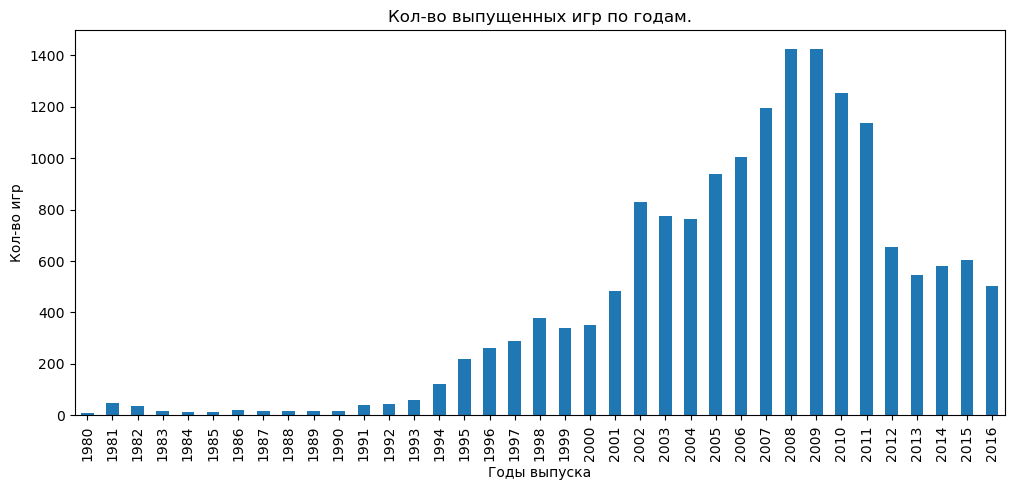

In [89]:
df.groupby('year_of_release')['year_of_release'].count().plot.bar(
    figsize=(12,5),
    title = 'Кол-во выпущенных игр по годам.',
    xlabel = 'Годы выпуска',
    ylabel = 'Кол-во игр'
);

По гафику видно что с 1993 года началось активное увеличение кол-ва продаваемых игр и достигло пика в 2008-2009 годах, после чего произошел спад и с 2012 года по 2016й кол-во продаж относительно стабильно с учётом того что данные за 2016 год не полны.
***

### Распределение продаж по платформам
[к выводу](#resume)  
[к началу](#list)
<a id='sales_per_platform'></a>
#### Сумарные продажди по платформам за всё время

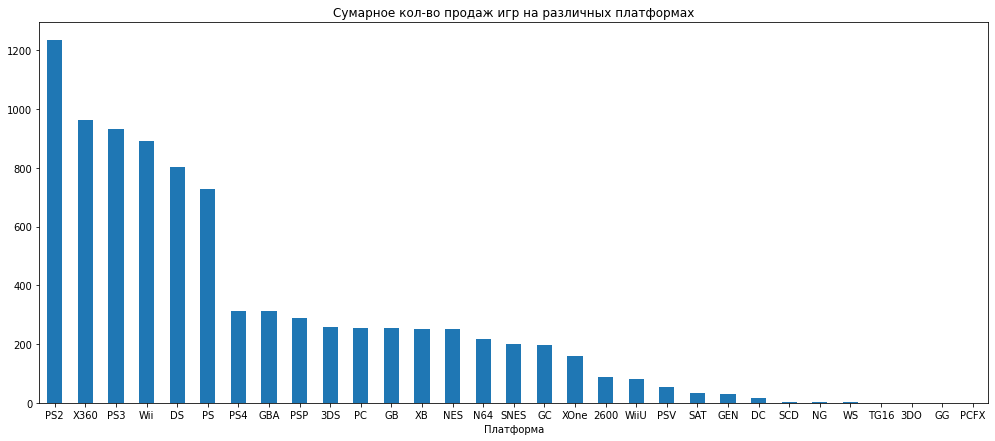

In [15]:
df.groupby('platform')['all_sales'].sum().sort_values(ascending=False).plot.bar(
    figsize=(17,7),
    rot=0,
    xlabel='Платформа',
    title = 'Сумарное кол-во продаж игр на различных платформах'
)
plt.show()

Как видно по графику распределения лидерами за всё время являются ранние PlayStation, XBox, консоли Nintendo.

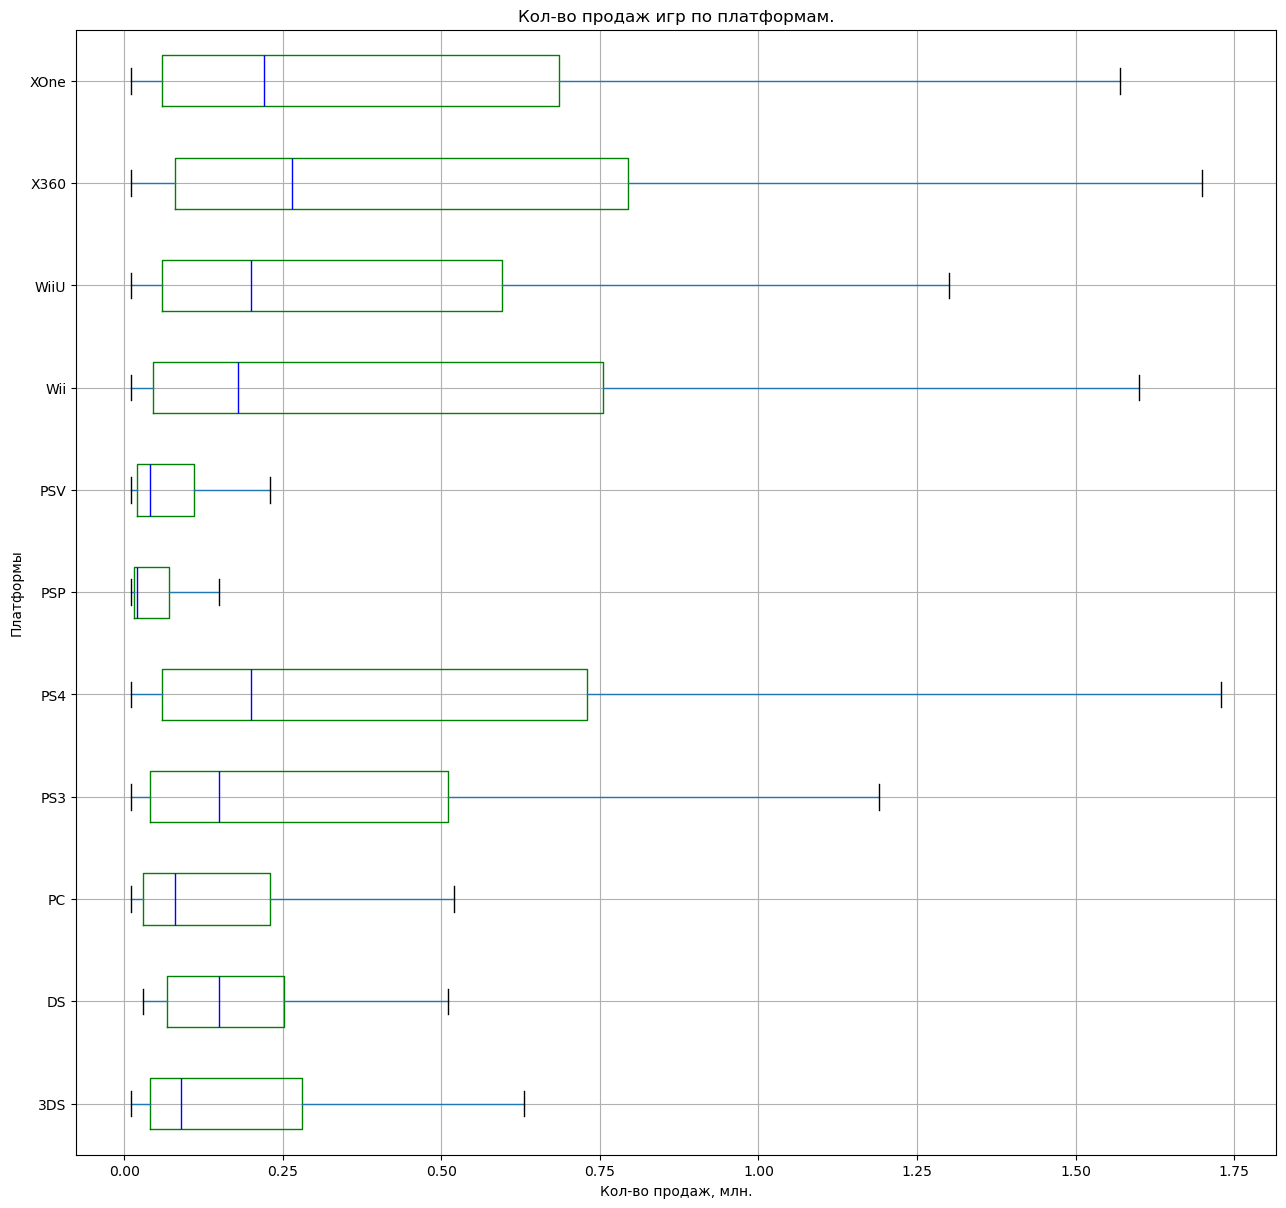

In [147]:
color = {
    "boxes": "Green",
    "medians": "Blue",
}
df.query('year_of_release>=2013').boxplot(
    column='all_sales',
    by='platform',
    vert=False,
    figsize=(15,15),
    showfliers=False,
    color=color,
    
)
plt.title('Кол-во продаж игр по платформам.')
plt.suptitle('')
plt.xlabel('Кол-во продаж, млн.')
plt.ylabel('Платформы');

По диаграммам размаха видно что перспективные платформы, выбранные ранее показывают хорошее кол-во продаж игр за выбранный период. Так-же хорошие данные показывают консоли предыдушего поколения из линейки перспективных платформ. Платформы чей срок жизни подходит к концу отличаются малыми продажами.

#### Динамика продаж среди топ-10 платформ по продажам за всё время + ПК
В следующем графике физуализируют топ-10 платформ по продажам игр на них, а так-же добавлю к ним ПК(как "вечноживущую" платформу) для сравнения.

In [95]:
top_10_platforms_by_sales = df.groupby('platform')['all_sales'].agg('sum').sort_values().tail(10).index
top_10_platforms_by_sales = top_10_platforms_by_sales.insert(0, 'PC')
list(top_10_platforms_by_sales)

['PC', '3DS', 'PSP', 'GBA', 'PS4', 'PS', 'DS', 'Wii', 'PS3', 'X360', 'PS2']

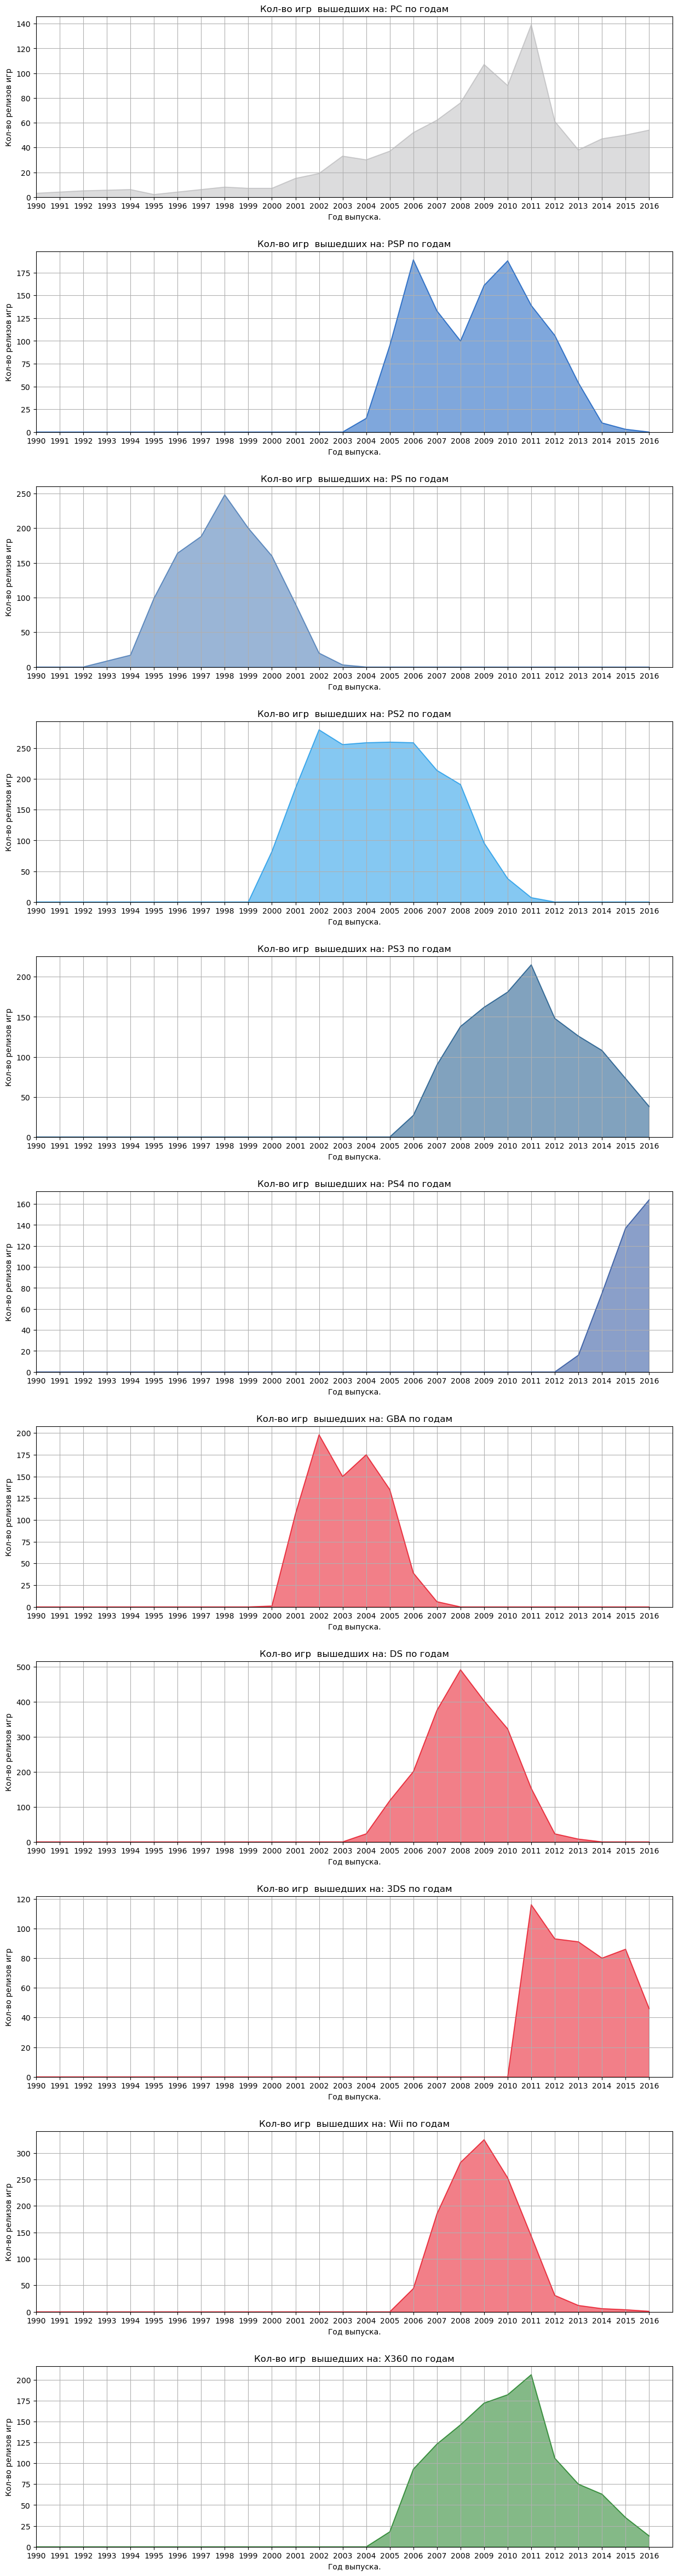

In [131]:
temp_df = (df
           .query('platform in @top_10_platforms_by_sales')
           .pivot_table(index = 'year_of_release', columns='platform', values='name', aggfunc='count')
          )
colors = {
    'PC': '#bababc', 
    '3DS': '#e60012',
    'PSP': '#0151ba',
    'PSV': '#0151ba',
    'GBA': '#e60012',
    'PS4': '#164194',
    'PS': '#366dae',
    'DS': '#e60012',
    'Wii': '#e60012',
    'WiiU': '#e60012',
    'PS3': '#04477e',
    'X360': '#0a7511',
    'XOne': '#0a7511',
    'PS2': '#0c92e7',
}
# отсортирую плотформы так, чтобы платформы одного производителя находились рядом и в хронологическом порядке
top_10_platforms_by_sales = ['PC','PSP', 'PS', 'PS2', 'PS3', 'PS4',  'GBA',  'DS',  '3DS', 'Wii', 'X360', ] 
fig = plt.figure(figsize=(15,60))
plt.subplots_adjust(hspace=0.3)
for i, platform in enumerate(top_10_platforms_by_sales):
    fig.add_subplot(len(top_10_platforms_by_sales),1,i+1)
    temp_df[platform].plot(
        kind = 'area',
        stacked=False,
        grid=True,
        xticks = [x for x in range(1990, 2017)],
        xlim = (1990,2017),
        xlabel = 'Год выпуска.',
        ylabel = 'Кол-во релизов игр',
        title = f'Кол-во игр  вышедших на: {platform} по годам',
        color = colors[platform] if platform in colors else 'y'
    
    )
    
del temp_df

Как видно по графикам средний возраст жизни платформ от 7-8 до 10 лет, при этом особо удачные решения могут жить и долше, однако пик активности и максимального кол-ва продаж игр под платформы составляет 3-5 лет. Также по графикам видно что с появлением следующего поколения консолей одного семейства начинает снижатся популярность предыдущего.

#### За актуальный период
Теперь посмотрим данные по платформам которые актуальны на 2015-2016 год

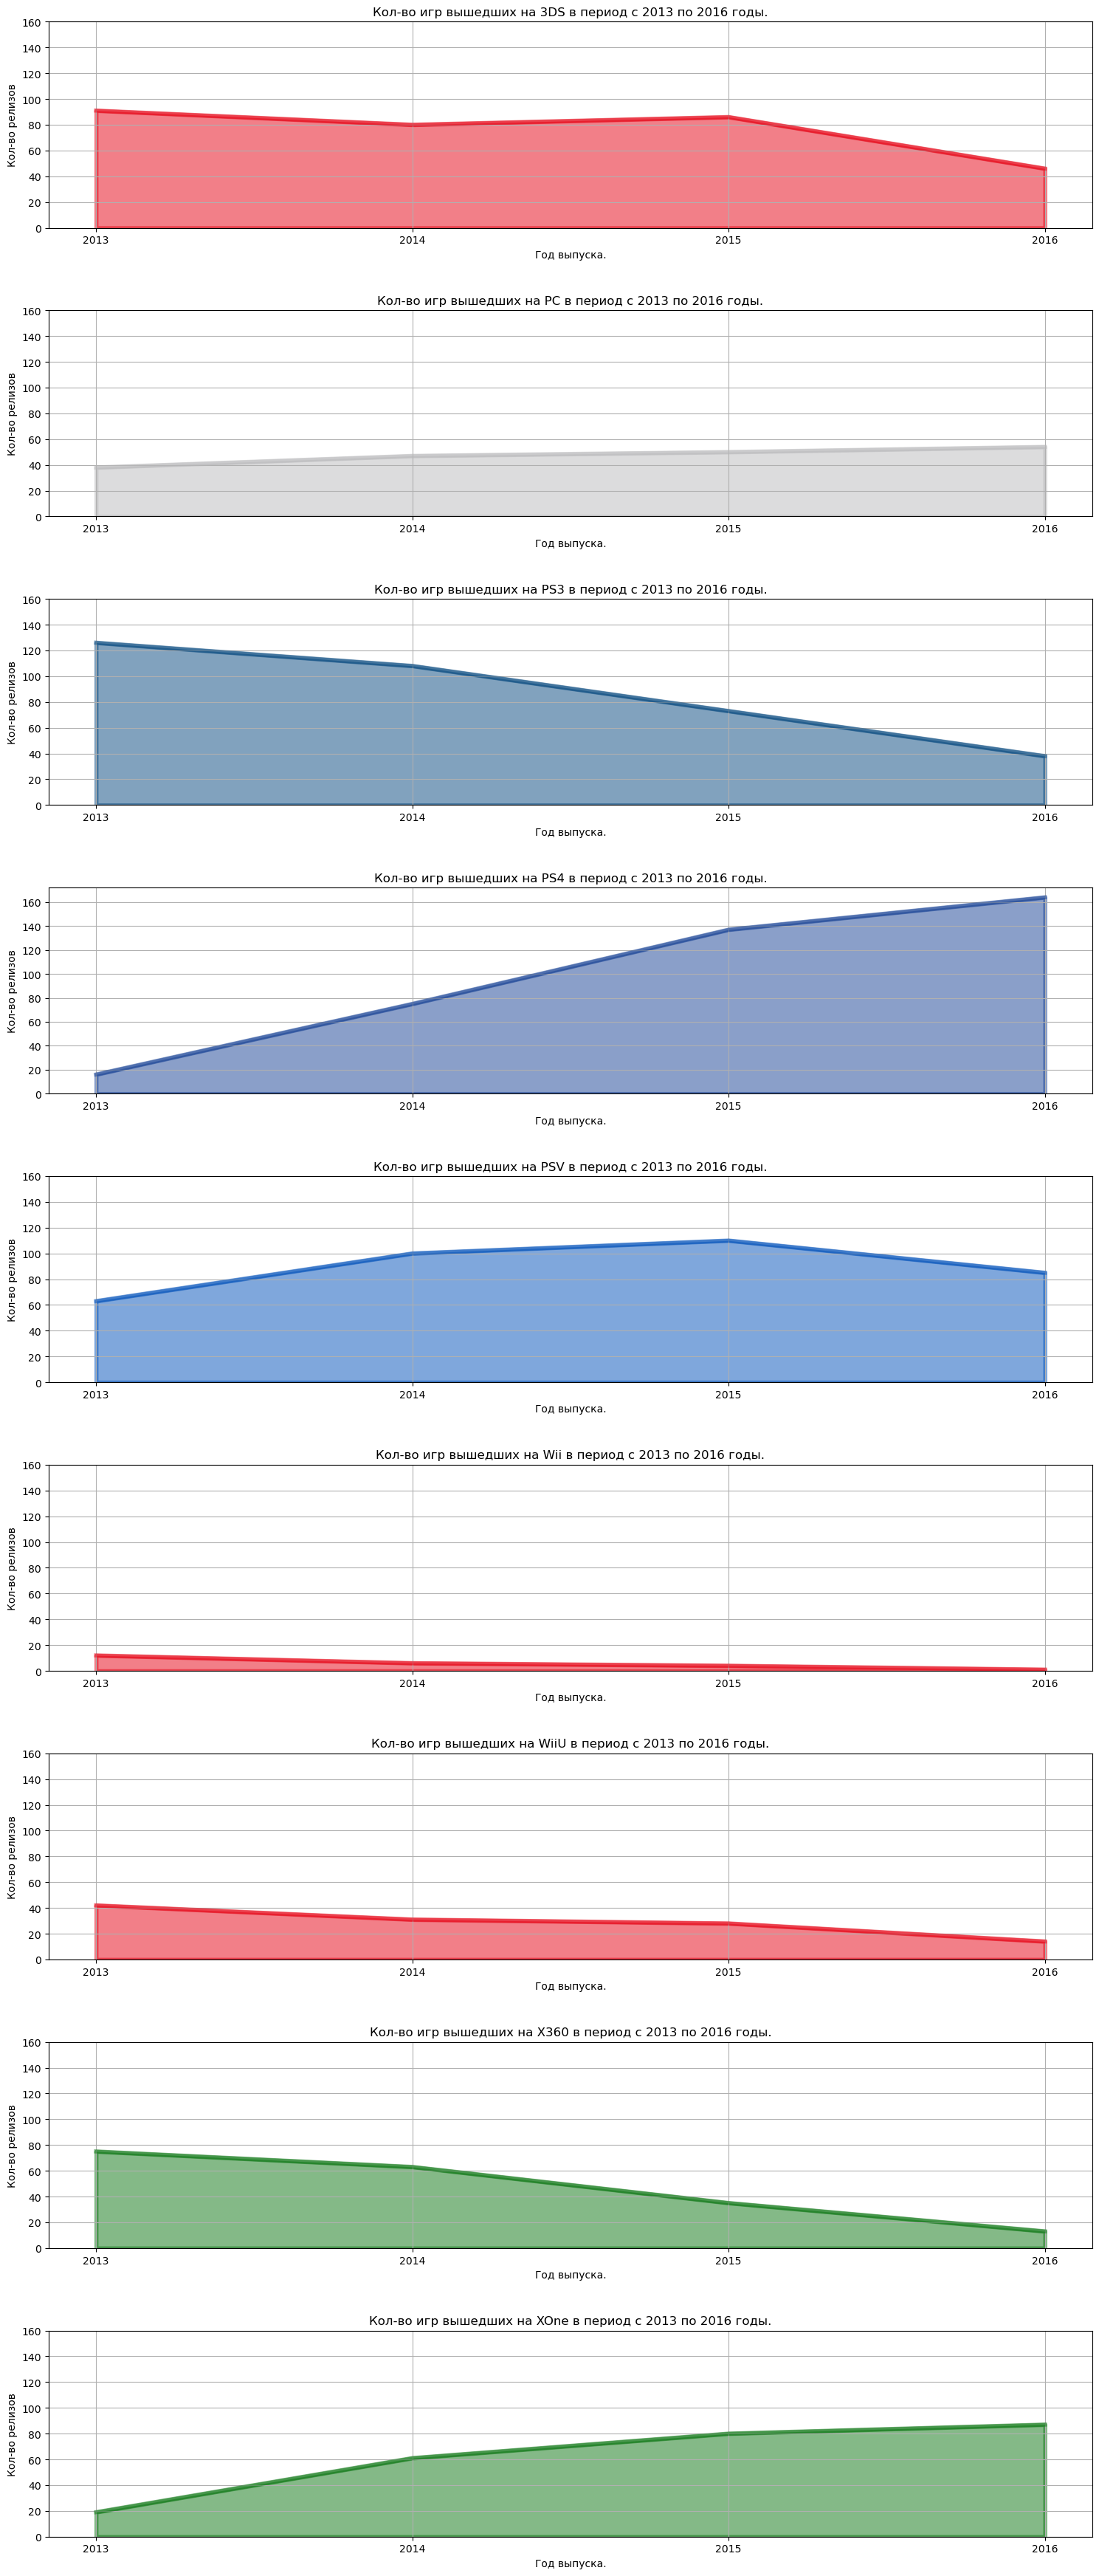

In [141]:
years=(2013,2016) # интересующий нас временной период
actual_platforms = df.query('year_of_release ==@years[1]')['platform'].unique()

temp_df = (df
 .query('(platform in @actual_platforms) & year_of_release>=@years[0]')
 .pivot_table(index = 'year_of_release', columns='platform', values='name', aggfunc='count')
          )

fig=plt.figure(figsize=(15,35))
for i, platform in enumerate(temp_df.columns):
    fig.add_subplot(len(temp_df.columns), 1, i+1)
    temp_df[platform].plot(
        #subplots=True,
        kind = 'area',
        stacked=False,
        grid=True,
        xticks = [x for x in range(years[0], years[1]+1)],
        yticks = [x for x in range(0,161,20)],
        #xlim=(years[0], years[1]),
        xlabel = 'Год выпуска.',
        ylabel = 'Кол-во релизов',
        lw=4,
        #colormap='Dark2',
        title = f'Кол-во игр вышедших на {platform} в период c {years[0]} по {years[1]} годы.',
        color = colors[platform] if platform in colors else 'y'
    )
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)

<a id='most_perspective'></a>
Как видно по графику наиболее перспективными платформами являютя **PS4**, **XOne**, **PC**. Продажи на остальных платформах падают а их активная жизнь подходит к концу.

### Влияние отзывов критиков и пользователей на продажи внутри одной платформы.
<a id='sales_critics_corr'></a>
[к выводу](#resume)  
[к началу](#list)  
Для анализа выберу PS4, XOne, PC

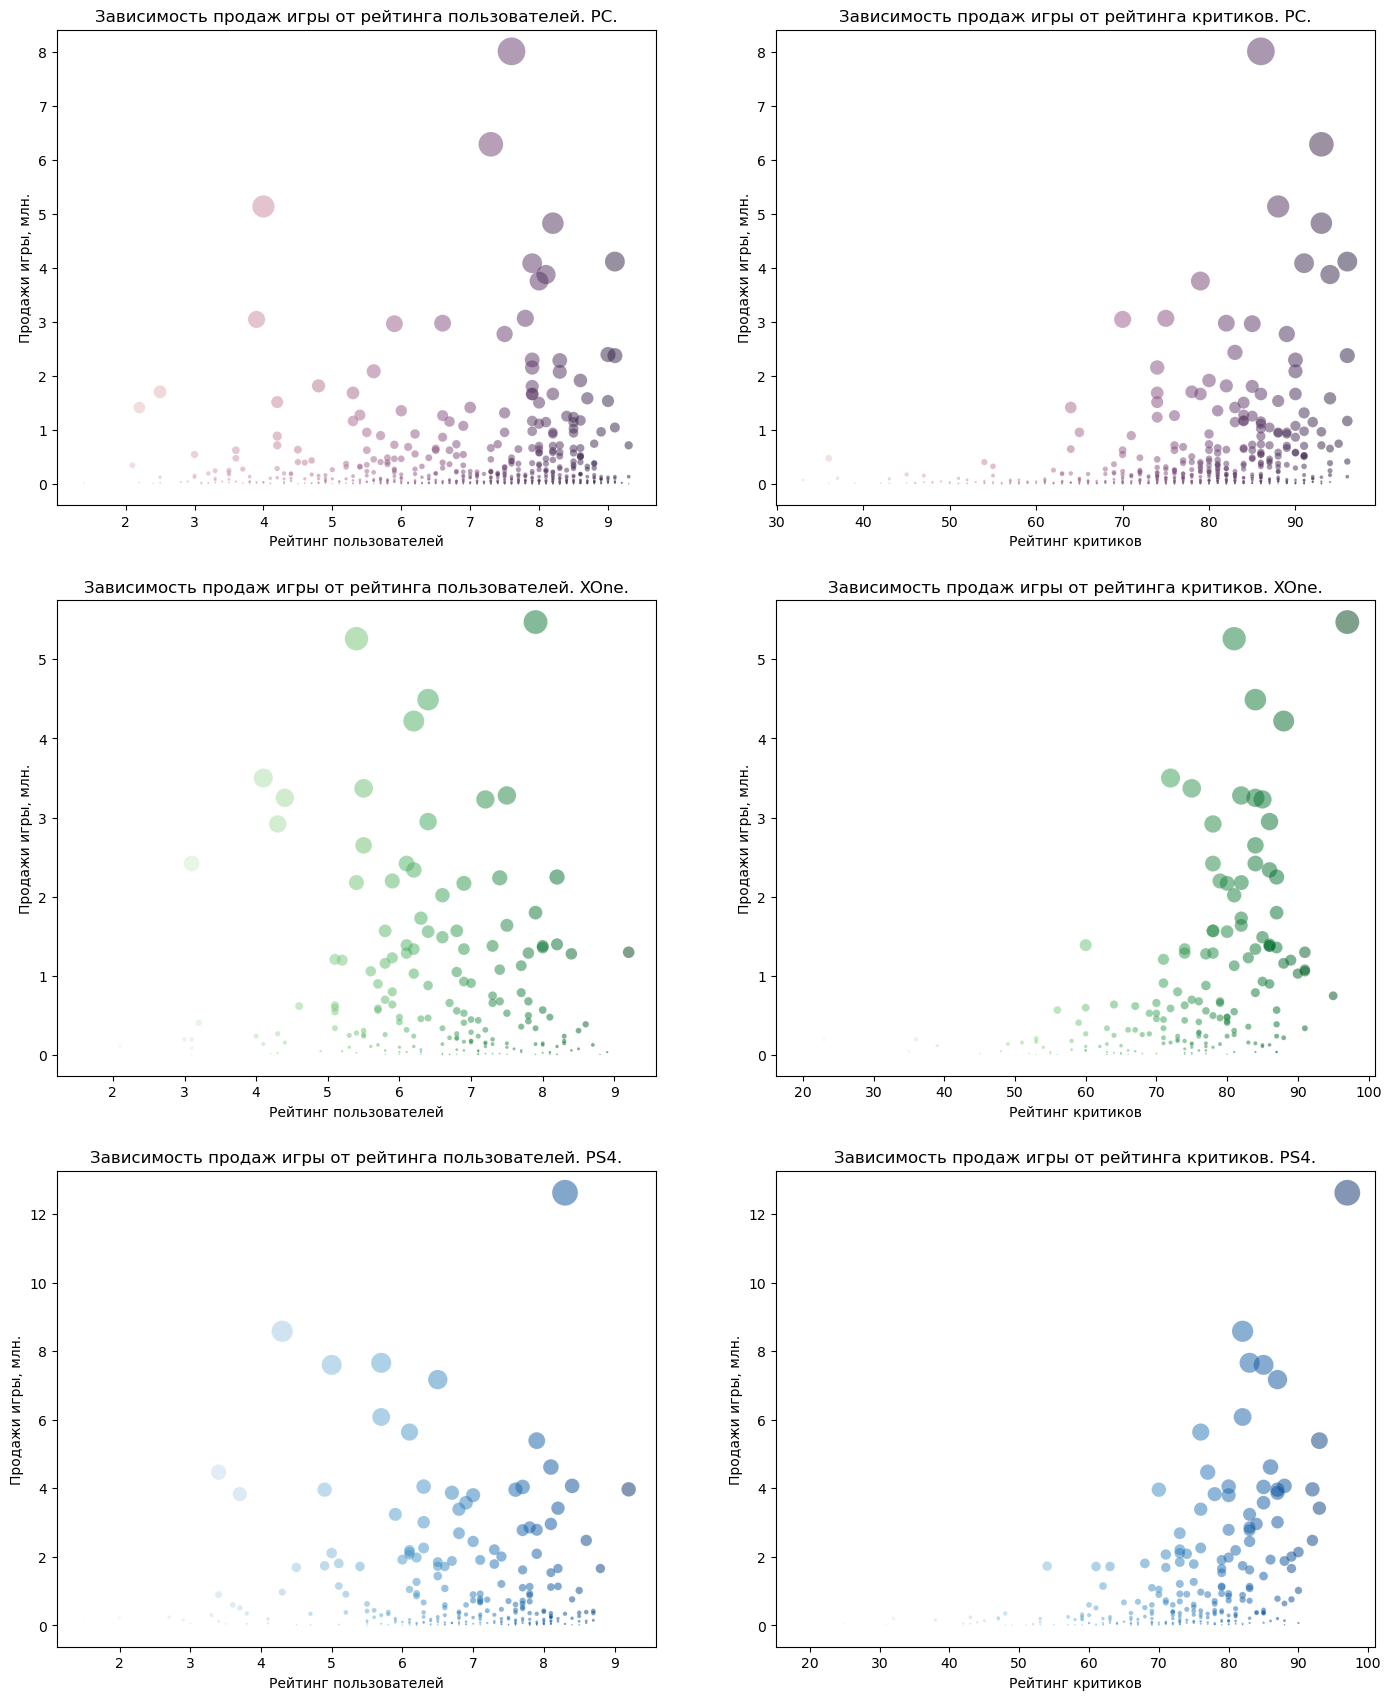

In [154]:
# PC
pos =1
fig = plt.figure(figsize=(17, 21))
for platform, palette in zip(["PC", "XOne", "PS4"], [None, "Greens", "Blues"]):
    for who, score in zip(["пользователей", "критиков"], ["user_score", "critic_score"]):
        fig.add_subplot(3,2,pos)
        sns.scatterplot(
            data = df.query(f'platform=="{platform}"'),
            y='all_sales', 
            x=score,
            alpha=0.5,
            hue = score,
            size = 'all_sales',
            legend=False,
            sizes = (1, 400),
            palette=palette
        )
        plt.title(f'Зависимость продаж игры от рейтинга {who}. {platform}.')
        plt.xlabel(f'Рейтинг {who}')
        plt.ylabel('Продажи игры, млн.')
        pos+=1

In [156]:
for platform in ['PC', 'XOne', 'PS4']:
    print(f'Корреляция продаж и оценки пользователей на {platform}:' 
          f'{df.query("platform==@platform")["user_score"].corr(df.query("platform==@platform")["all_sales"]):.4f}')
    print(f'Корреляция продаж и оценки пользователей на {platform}:' 
          f'{df.query("platform==@platform")["critic_score"].corr(df.query("platform==@platform")["all_sales"]):.4f}')
    print()

Корреляция продаж и оценки пользователей на PC:0.0129
Корреляция продаж и оценки пользователей на PC:0.2574

Корреляция продаж и оценки пользователей на XOne:-0.0689
Корреляция продаж и оценки пользователей на XOne:0.4170

Корреляция продаж и оценки пользователей на PS4:-0.0320
Корреляция продаж и оценки пользователей на PS4:0.4066



<a id='score_corr'></a>
По графикам и коэффициэнтам корреляции видна связь между низкой оценкой критиков и низкими продажами игр. При этом чем выше оценка тем выше разброс в кол-ве продаж, из чего следует что высокая оценка критиков не гарантирует высокие продажи, но низкая (ниже среднего) оценка указывает на не прибыльный продукт. Однако стоит учитывать и наличие "нишевых" проектов для узкой аудитории которые могут получать хорошие оценки, быть хорошими и качественными играми, но не будут хорошо продаватся из-за их не популярности. Нишевость продукта также влияет и на кореляцию продаж и оценок пользователей. Ещё одним фактором может быть "нечестность" критика который ради личный выгоды поставит хорошую оценку плохому продукту, так-как отзывы критиков могут влиять на мнения общественности, то нечестные издатели могут подкупить их мнение.  
При этом корреляция с оценками пользователей не наблюдается. Это может быть связано с тем что мнение игроков об игре формируется после её покупки что может приводить к тому что ожидаемый "в народе" проект будет приобретён большим кол-вом людей чьих ожиданий он не оправдает, после чего его пользовательский рейтинг существенно пострадает. Так-же мнение критиков может повлиять на мнение потенциальных покупателей что повысит продажи продукта который оценили критики но не оценят пользователи.

### Распределение игр по жанрам.

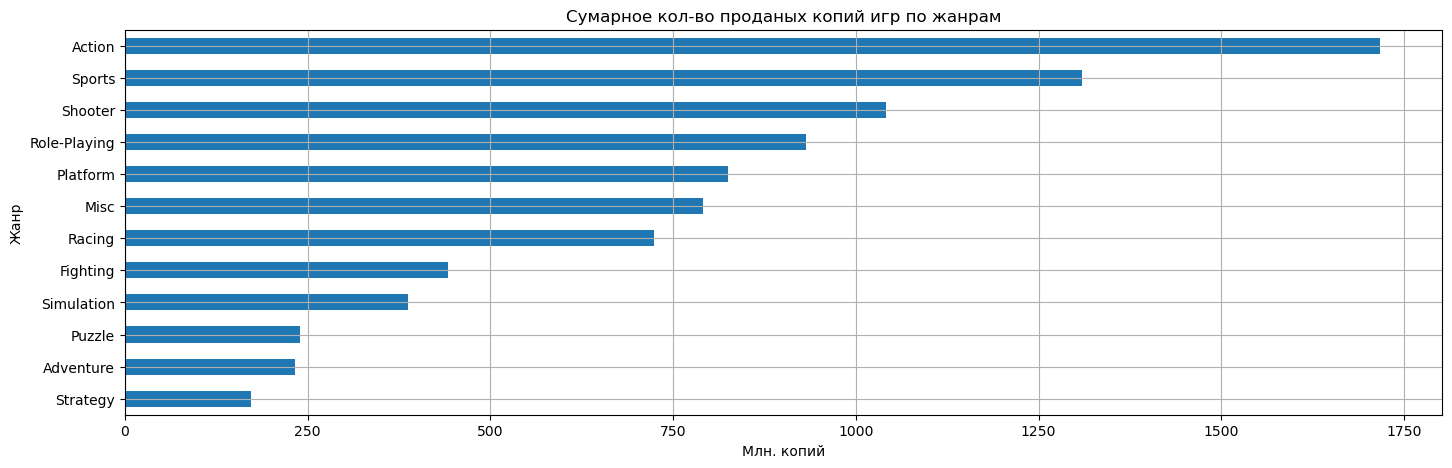

In [160]:
(df
 .pivot_table(index='genre', values='all_sales', aggfunc='sum')
 .sort_values(by='all_sales')
 .plot.barh(
     figsize=(17,5),
     legend=False,
     grid=True,
     xlabel = 'Млн. копий',
     ylabel = 'Жанр',
     title = 'Сумарное кол-во проданых копий игр по жанрам'
 )
);

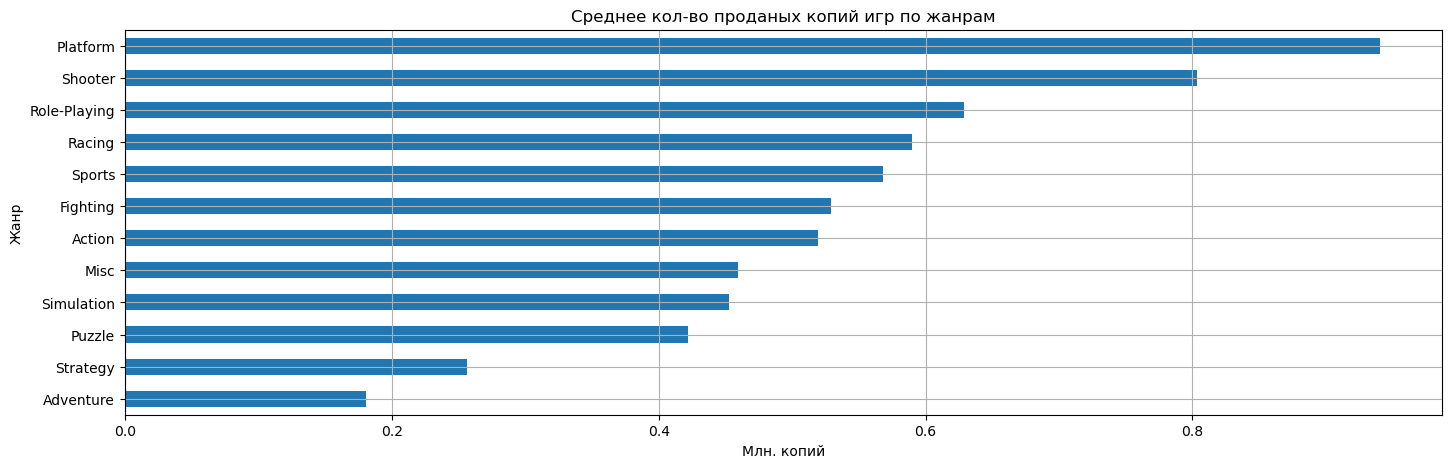

In [164]:
(df
 .pivot_table(index='genre', values='all_sales', aggfunc='mean')
 .sort_values(by='all_sales')
 .plot.barh(
     figsize=(17,5),
     legend=False,
     grid=True,
     xlabel = 'Млн. копий',
     ylabel = 'Жанр',
     title = 'Среднее кол-во проданых копий игр по жанрам'
 )
);


По двум графикам видно что лидирующий по сумарным продажам жанр Action в среднем на игру продаётся хуже что говорит о большом кол-ве не очень популярных игр в данном жанре. В среднем же наиболее продаваемыми жанрами являются: платформеы, шутеры, RPG, гонки с существенным отрывом в большую сторону для платформеров и шутеров, что для шутеров объяснимо большим кол-во выпускаемых ААА игр в данном жанре а для платформеров наличием крайне популярных и старых серий игр, например Mario, игры из которой обычно хорошо продаются.  
Однако стоит учитывать и особенность платформ на которых выходят игры, те-же платформеры наиболее популярны на портативных консолях, стратегии на консолях наоборот, популярностью не пользуются, в том числе из-за сложности реализации стратегического управления, другие особенности жанров и платформ тоже стоит учитывать, но если смотреть на общую картину то представленные выше два графика наиболее подходят для её описания.

## Портрет пользователя каждого региона
<a id='jap_dif'></a>

### Популярность платформ по регионам. Топ-5
<a id='top5_platform'></a>
[к началу](#list)  
[к выводу](#resume)

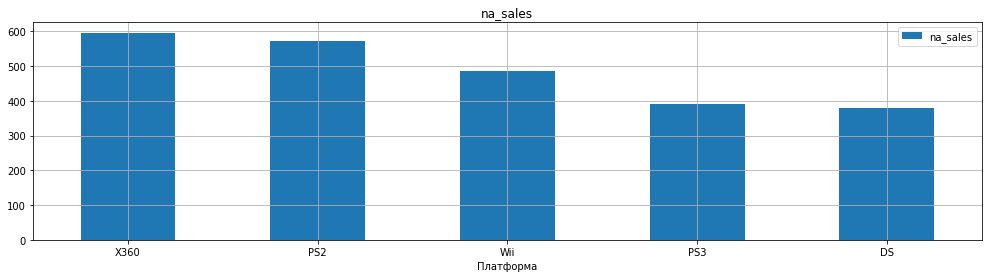

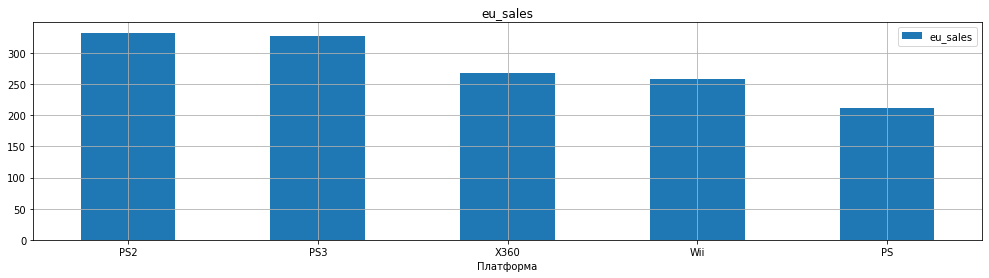

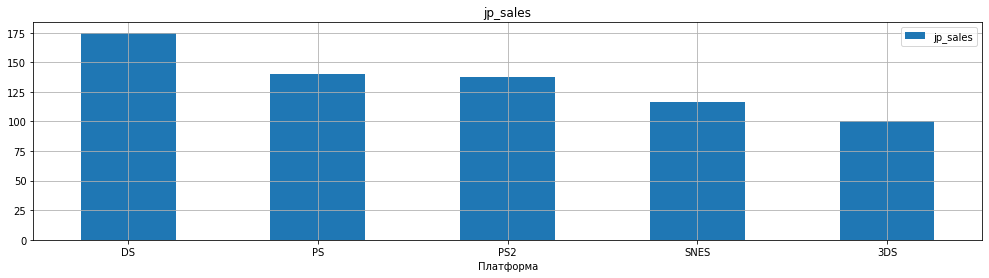

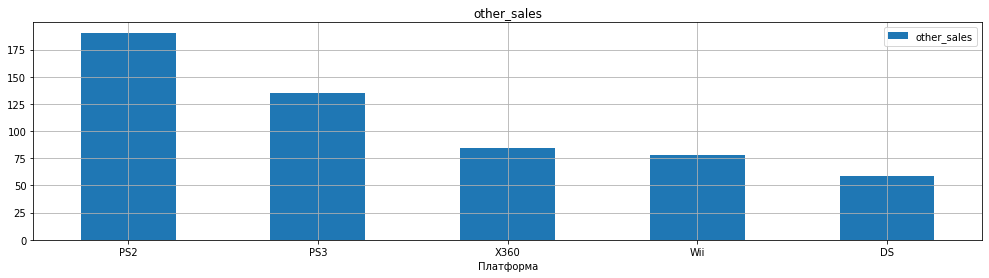

In [24]:
for region in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']:
    (df
    .pivot_table(index='platform', values=region, aggfunc='sum')
    .sort_values(by=region, ascending=False)
    .head(5)
    .plot.bar(subplots=True, figsize=(17,4), grid=True, rot=0, xlabel='Платформа')
    )

По графикам видно различие между регионами. Так в японии наиболее популярны портативные консоли Nintendo, в Европе больше любят линейку PlayStation а в Северной Америке XBox. При этом PS2 и PS3 имеют достаточно высокую популярность во всех регионах.  
Стоит обратить внимание и на числовые значения продаж, так в Северо-Американском регионе сумарные продажи для самых популярных консолей находятся в районе 400-600 млн. проданых копий игр, что вдвое больше чем в Европейском и почти в 4 раза больше чем в Японскогом регионе. В прочих регионах продажи намного меньше и разница между лидирующими платформаи более значительна. Так и в Европе и в других регионах на первом месте находится PS2 а на третьем xBox 360 но разница между продажами на этих платформах для прочих регионов почти двукратная в то время как в Европе продажи игр для XBox меньше на $\frac16$.


### Популярность жанров по регионам. Топ-5

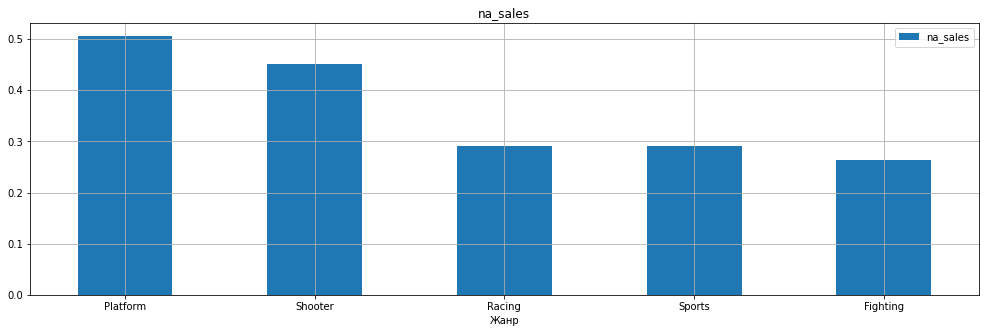

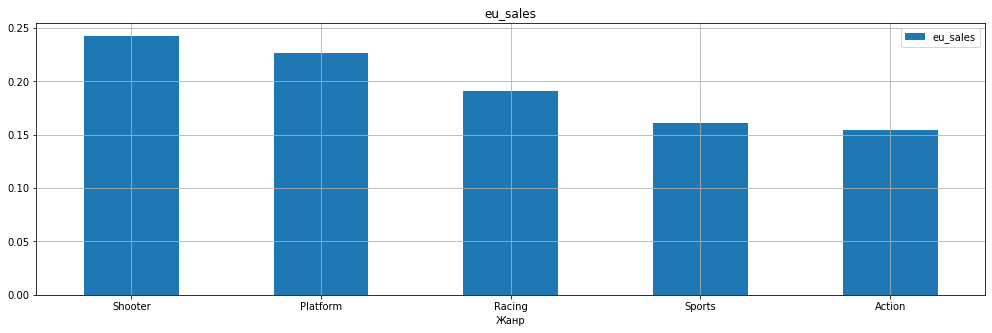

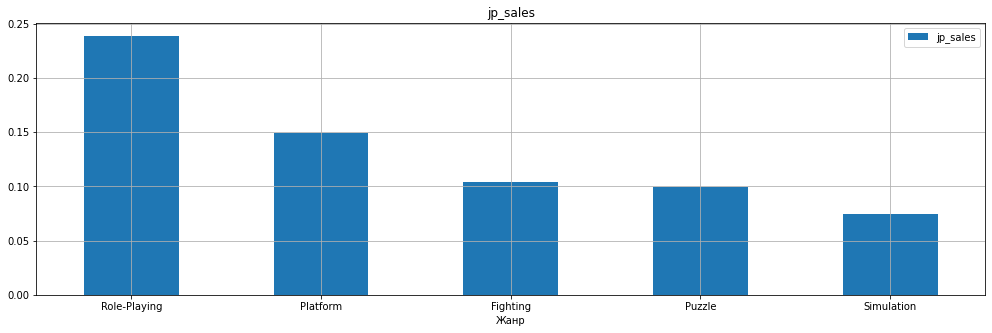

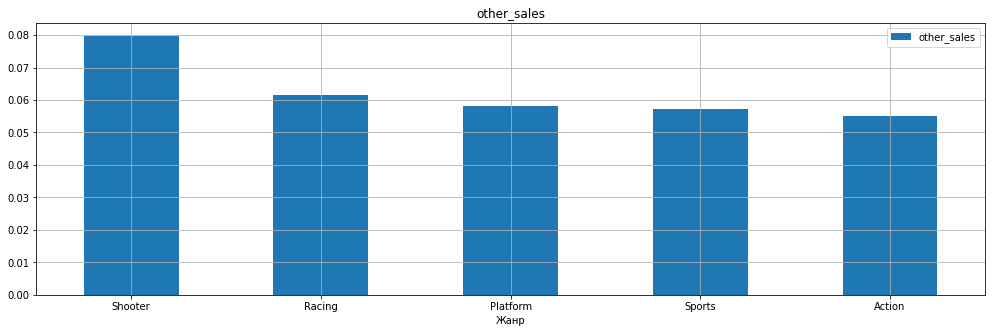

In [25]:
for region in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']:
    (df
    .pivot_table(index='genre', values=region, aggfunc='mean')
    .sort_values(by=region, ascending=False)
    .head(5)
    .plot.bar(subplots=True, figsize=(17,5), grid=True, rot=0, xlabel='Жанр')
    )

По графикам видны региональные предпочтения в жанрах: в Европе и Америке наибольшие средние продажи у  шутеров, платформеров, гоночных и спортивных игр. В Японии средние продажи наиболее высоки для жанров RPG, платформеров, и файтингов. В остальных регионах предпочтения коррелируют с Американо-Европейскими, что выделяет азитский рынок видеоигр.  
Средние продажи по жанрам в Америке составляют пол-миллиона копий на игру, что в два раза больше чем в Европе и Японии, из-за этих различий более популярный в Японии жпнр файтингов, в среднем продается в 2,5 раза хуже чем в Америке, где этот жанр менее популярен. Средние продажи лидирующих жанров в Японии чуть меньше Европейских но схожи с ними, при этом разница в средних продажах среди лидеров для Японии куда выше.
В других регионах продажи популярнейших жанров схожи, за исключение шутеров, занимающих лидирующее место и в середнем превосходящих другие жанры на $\frac13$. 


### Влияние рейтинга ESRB на продажи в регионах.

Для отражения игр без рейтинга заполню пропуски в колонке `rating` значением 'not_rated'.  
Так-же возьму относительно современные данные.

In [26]:
df['rating'] = df['rating'].fillna('not_rated')


,eu_sales,jp_sales,na_sales,other_sales
rating,,,,
E,113.03,28.33,114.37,31.44
E10+,55.37,8.19,75.70,16.23
M,193.96,21.20,231.57,63.38
T,52.96,26.02,66.02,17.94
not_rated,91.50,108.84,103.31,27.17


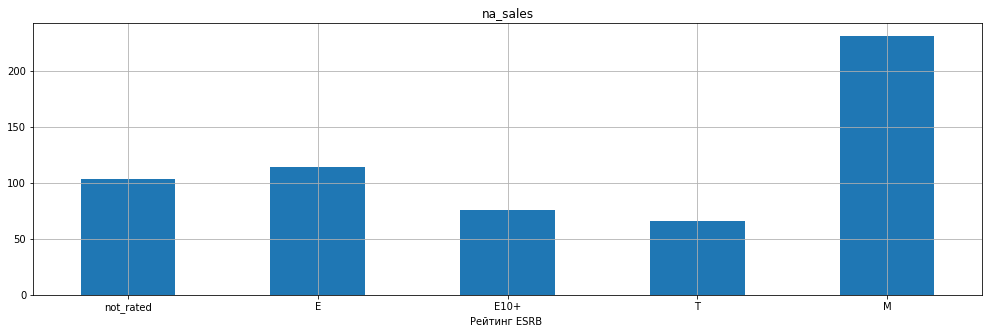

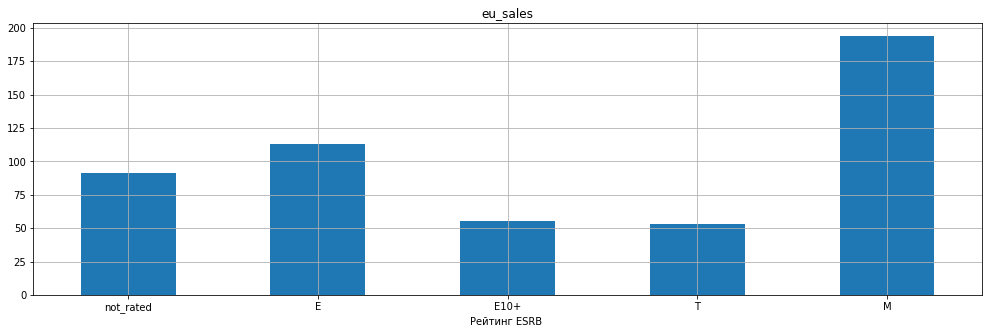

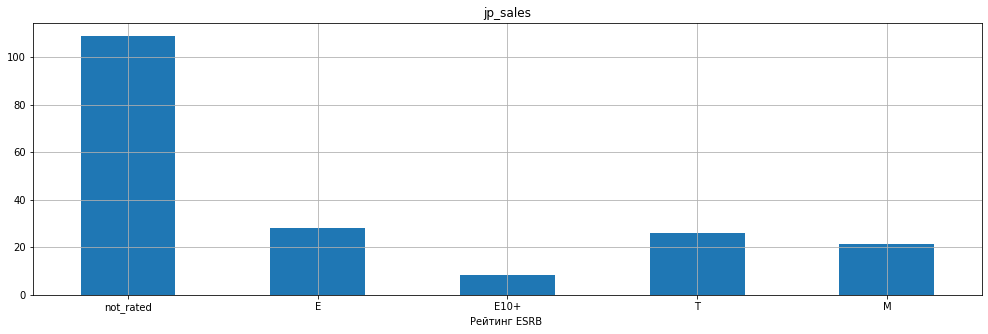

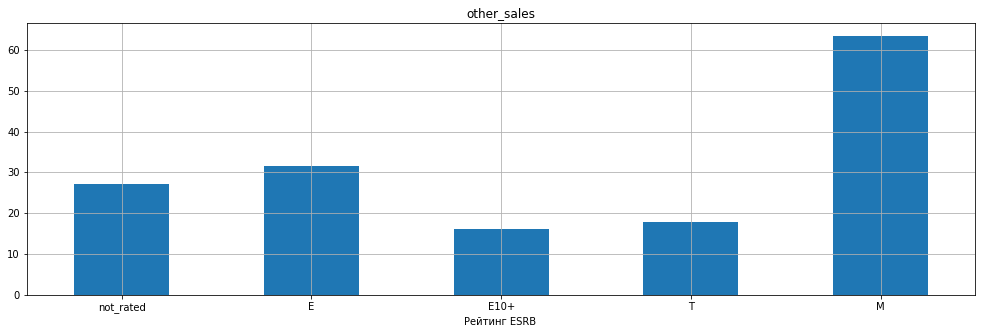

In [27]:
rating_sales = (df
.query('year_of_release >=2012')
.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], aggfunc='sum')
               )
display(rating_sales)
rating_sales['rating_order'] = [1,2,4,3,0]#[5,1,2,0,4,6,3,7]
rating_sales = rating_sales.sort_values(by='rating_order')
for region in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']:
    (rating_sales[region]
    .plot.bar(figsize=(17,5), grid=True, rot=0, title=region, xlabel='Рейтинг ESRB ')
    )
    plt.show()

По графикам видно ещё одно региональное различие: в Японии большинсво проданных игр не имеет рейтинга что вероятнее всего означает, что эти игры от небольших или независимых студий, это скорее всего небольшие и простые в производстве (в сравнении с AAA проектами) игры.  
Так-же это может означать то, что в Японии игры маркируются другой возрастной рейтинговой системой, как например в Европе игры так-же могут маркироватся в системе PEGI.
Кроме-того сушественное различие в количестве взрослых игр для Японии так-же может означать нацеленность крупных издателей на более молодую возрастную категорию, что может быть связано с меньшим кол-вом свободного времени у взрослых Японцев чем у взрослых Европейцев и Американцев, что объясняется известным Японским трудоголизмом.

## Проверка гипотез.

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
$H_0: \mu_{PC} = \mu_{XOne}$  - гипотеза соответствующая сути вопроса  
$H_1: \mu_{PC} \neq \mu_{XOne}$

In [28]:
alpha = 0.01
t = ' & year_of_release>=2012'
result = st.ttest_ind(
    df.query('platform == "PC" & ~user_score.isna()' + t)['user_score'],
    df.query('platform == "XOne" & ~user_score.isna()' + t)['user_score'],
)
print(f'''p-value: {result.pvalue}
{"Не отергаем нулевую гипотезу" if result.pvalue>=alpha else "отвергаем нулевую гипотезу"}
Средний рейтинг PC: {df.query('platform == "PC" & ~user_score.isna()' + t)['user_score'].mean():.2f}
Средний рейтинг Xbox One: {df.query('platform == "XOne" & ~user_score.isna()' + t)['user_score'].mean():.2f}''')

p-value: 0.5535102819461235
Не отергаем нулевую гипотезу
Средний рейтинг PC: 6.43
Средний рейтинг Xbox One: 6.52


Такую схожесть рейтингов можно объяснить началом более тесной интеграции консолей XBox и операционной системы Windows. Многие игры выходящие на XBox вероято, в схожем качестве портировались и на ПК.

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
$H_0: \mu_{A} = \mu_{S}$  
$H_1: \mu_{A} \neq \mu_{S}$ - гипотеза соответствующая сути вопроса

In [29]:
alpha = 0.01
result = st.ttest_ind(
    df.query('genre == "Action" & ~user_score.isna()' + t)['user_score'],
    df.query('genre == "Sports" & ~user_score.isna()' + t)['user_score'],
)
print(f'''p-value: {result.pvalue}
{"Не отергаем нулевую гипотезу" if result.pvalue>=alpha else "отвергаем нулевую гипотезу"}
Средний рейтинг Action: {df.query('genre == "Action" & ~user_score.isna()' + t)['user_score'].mean():.2f}
Средний рейтинг Sports: {df.query('genre == "Sports" & ~user_score.isna()' + t)['user_score'].mean():.2f}''')

p-value: 3.716101071226201e-26
отвергаем нулевую гипотезу
Средний рейтинг Action: 6.83
Средний рейтинг Sports: 5.46


Средний рейтинг этих жанров дейсвтительно отличается и не в лучшую сторону для спортивных игр, что может сигнализировать об увеличении игр низкого и среднего качества в данном жанре.

## Общий вывод.
<a id='resume'></a>
[к началу](#list)

##### В ходе исследования были изучены данные о продажах игр на различных платформах за разные годы, и в разных регионах. 
**Были визуализированны такие особенности как**: 
- Кол-во игр выпущенных за разные годы;
- Наиболее популярные платформы по кол-ву проданных копий игр;
- Влияние отзывов на продажи среди перспективных платформ;
- Кол-во игр по жанрам.

**Данные визуализации позволили сделать выводы о**:
- Росте популярности игровой индустрии начиная с 1993 с достижением пика примерно в 2009, и  снижении сумарного кол-ва продаж с 2012 года. 
- Среди платформ наблюдается конкуренция трех основных представителей: XBox, PlayStation и Nintendo а также Персональные Компьютеры которые, хотя и не относятся напрямую к развлекательным устройствам, всё равно имеют значительную  популярность в качестве игровой платформу. 
- Игровые консоли же, как было выеснено по визуализированным данным имеют ограниченный срок жизни (обычно 6-10 лет с пиком популярности в 4-6 лет), после выпуска новой консоли в одном семействе популярность предыдущей постепенно падает а новой растёт.  
- была обнаружена связь с оценкой критиков и продажами игр, связь же с отзывами игроков обнаружена не была и игры с большим кол-вом продаж могут получать множество нелестных отзывов от простых пользователей. О возможных причинах было описано [под графиками](#score_corr) визуализирующими данные связи.
- Были определены наиболее 'продаваемые жанры', топ-3 занимают платформеры, шутеры и RPG (средние продажи игры по всем регионам за все годы)

Ещё одим шагом исследования было составление портрета игрока в зависимости от региона.  Были обнаружены предпочтительные платформы и жанры, влияние возрастных рейтингов на продажи игр. Кроме того были обнаружены различия в региональных предпочтениях, так Японский рынок видеоигр [существенно отличается](#jap_dif) от Европейско-Американского.

**В итогам проверки гипотез:**
- Гипотеза о равенстве средних рейтингов для платформ XBox One и PC не была отвергнута
- Была отвергнута гипотеза о неравенстве средних рейтингов жанров Action и Sport.

**По итогам исследования можно сделать вывод что:**
- [наиболее перспективными платформами](#most_perspective) являются **XBox One**, **Play Station 4** и **PC**. 
- Рекламные же компании для разных регионов должны различатся: для Японии стоит сделать ставку на небольшие проекты в жанрах RPG, платформер, файтинг. Для европейских регионов стоит больше уделить внимания шутерам, платформерам и гонкам. Для Северной Америки стоит [активнее рекламировать](#top5_platform) игры для **XBox**, в Европе для **Play Station** а в японии для консолей **Nintendo**.